In [1]:
import numpy as np
import configparser
import pandas as pd
import tdr_utils as ut

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('tdr-parameters.ini')

c = float(config['signal']['c']) #speed of light
vf = float(config['signal']['vf']) #velocity factor
threshold = int(config['signal']['threshold'])
frequency = float(config['signal']['frequency'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

num_edges = int(config['search']['num_edges']) #number of rising and falling, each, edges to search for
overlap_offset = int(config['search']['overlap_offset']) #number of samples to offset overlap threshold with

win_size = int(config['win_interest']['win_size']) 
prior_samples = int(config['win_interest']['prior_samples']) # samples to consider before rising/falling edge index

_num_edges = 1
overlap_threshold = duty_cycle * (sampling_rate / frequency) - overlap_offset
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

### 12.41 m
Short circuit at 12.41 m from the input port

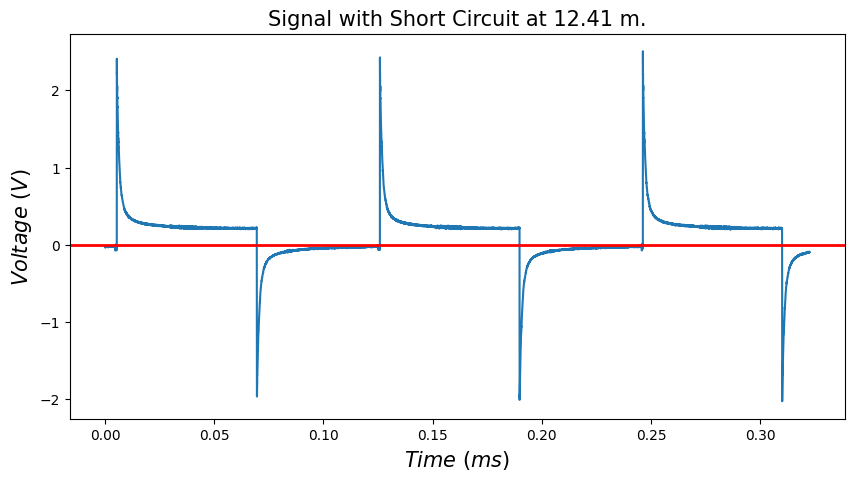

In [3]:
short_12m_files_dir = './data/short-circuit/12m'

#load a random file
v_short_12m = ut.random_file_load(short_12m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_12m, 'Signal with Short Circuit at 12.41 m.')

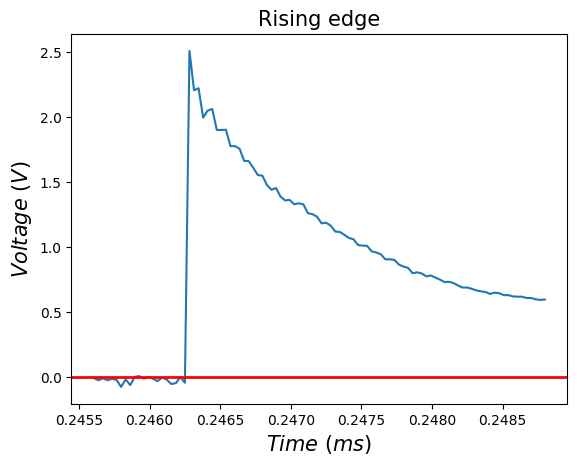

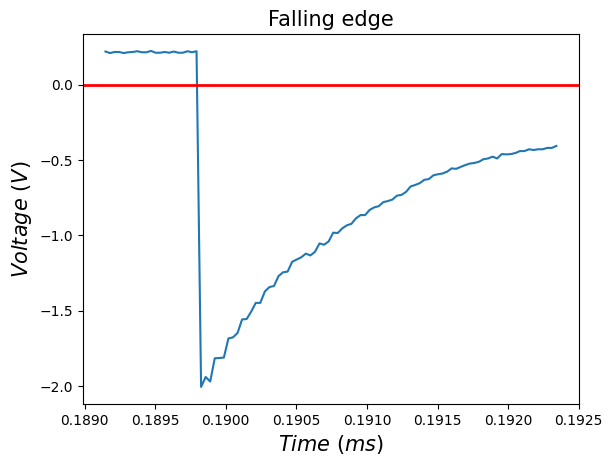

In [4]:
#locate rising a rising edge and a falling edge in the signal
short_12m_edges_indices = ut.edges_detection(v_short_12m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_12m, t, short_12m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

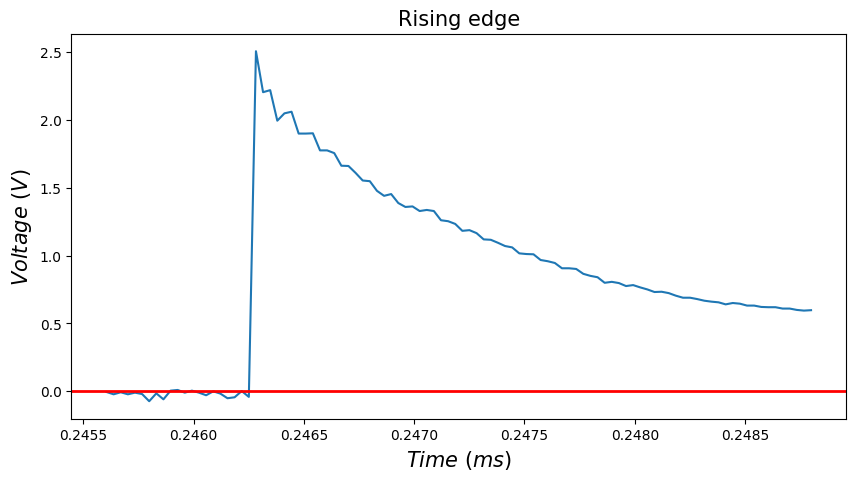

In [5]:
rising_edge_indx = short_12m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_12m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

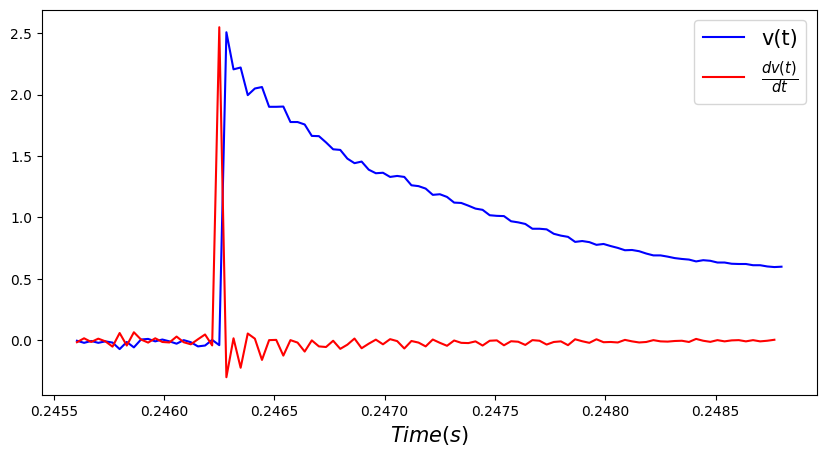

In [6]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

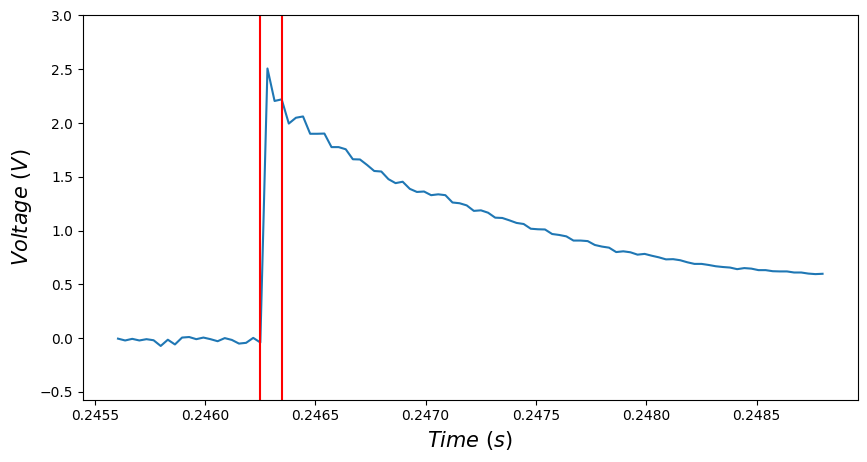

Timed delay is 9.678387193556848e-05 ms


In [7]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [8]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 14.206904561422098 m


In [9]:
#model performance
performance = ut.performance_metrics(12.41, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=3.2288660028595415, rmse=1.7969045614220978)


#### 2. Falling edge

Change point detection on a falling edge

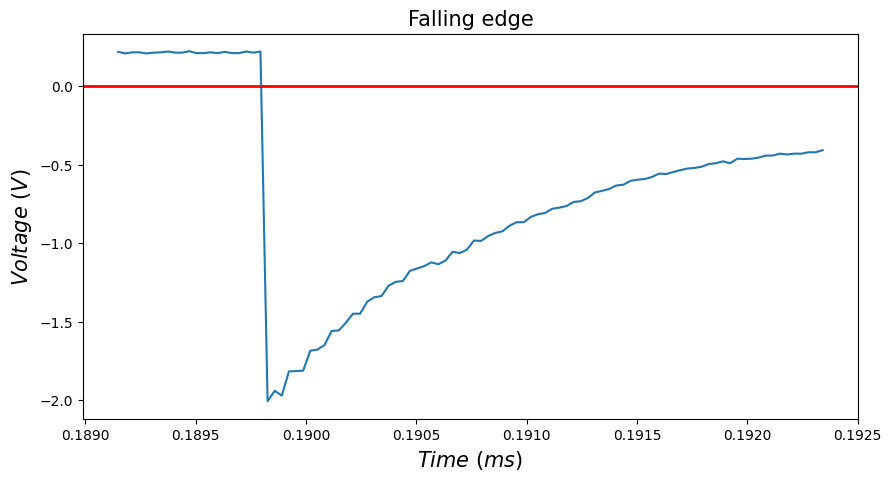

In [10]:
falling_edge_indx = short_12m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_12m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

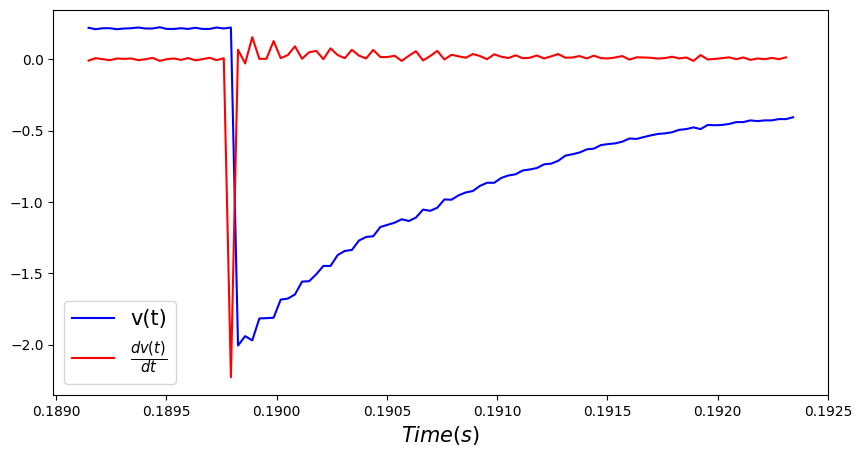

In [11]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

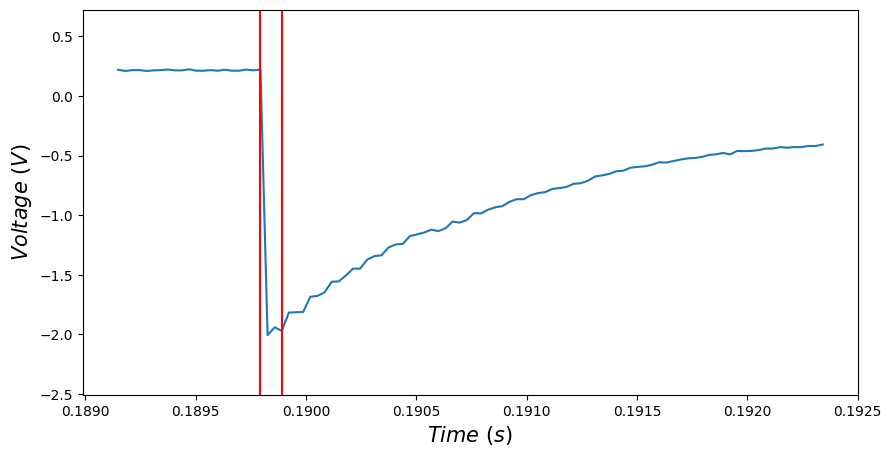

Timed delay is 9.678387193559623e-05 ms


In [12]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [13]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 14.206904561426171 m


In [14]:
#model performance
performance = ut.performance_metrics(12.41, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=3.2288660028741796, rmse=1.796904561426171)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [15]:
#locate rising rising edges and a falling edges in the signal
short_12m_edges_indices = ut.edges_detection(v_short_12m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_12m_edges_indices)

{'rising_edges': [167, 3901, 7633], 'falling_edges': [5883, 2154, 9610]}


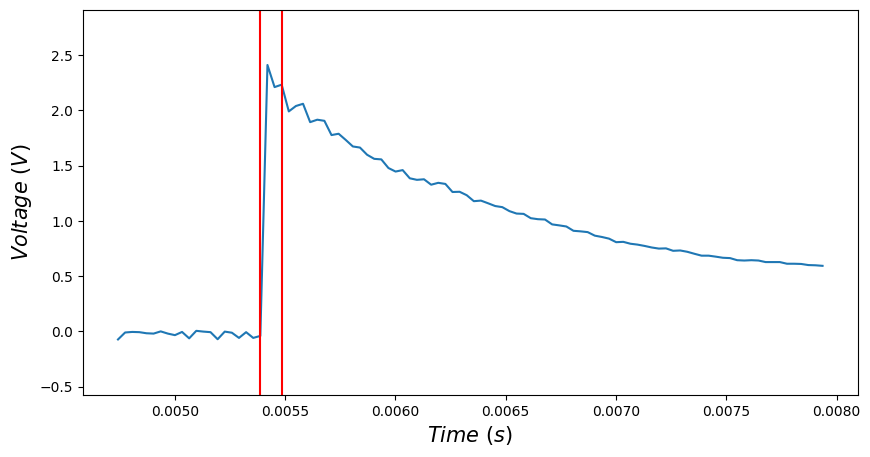

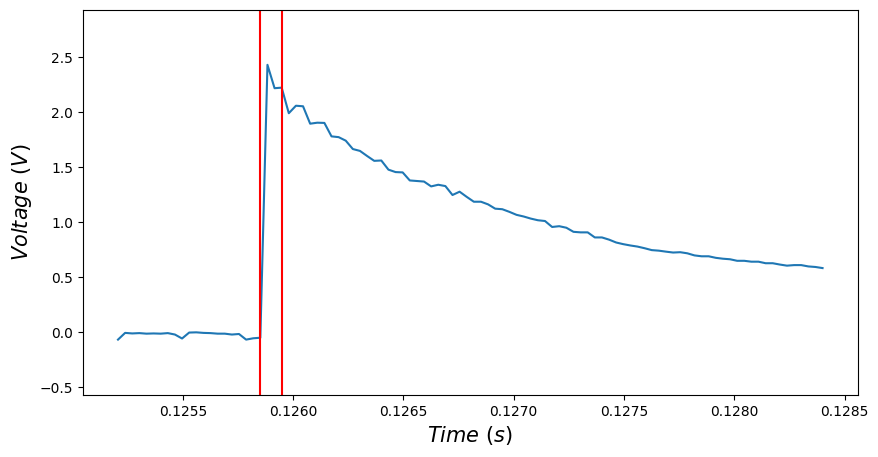

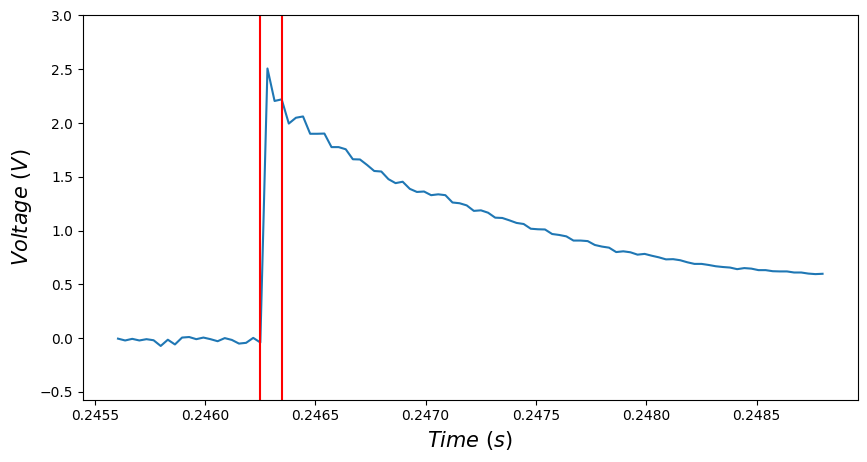

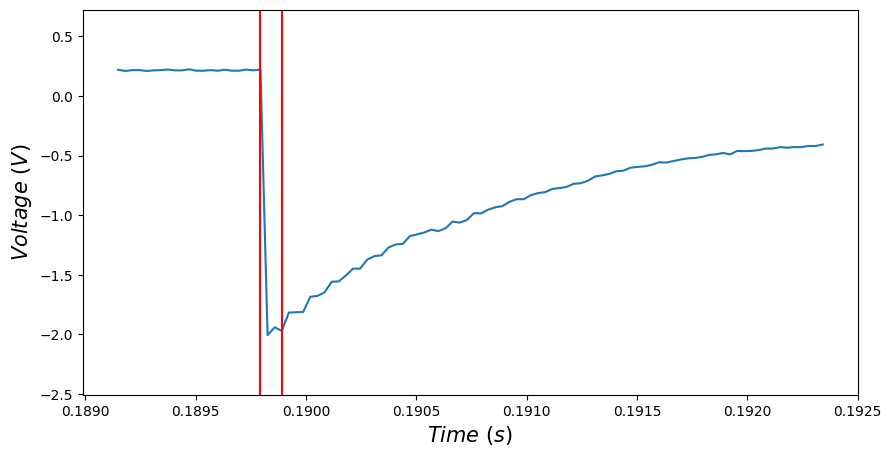

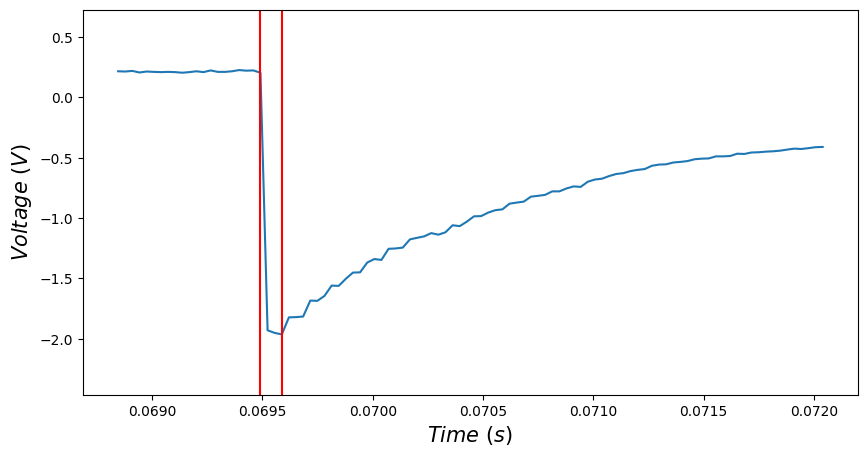

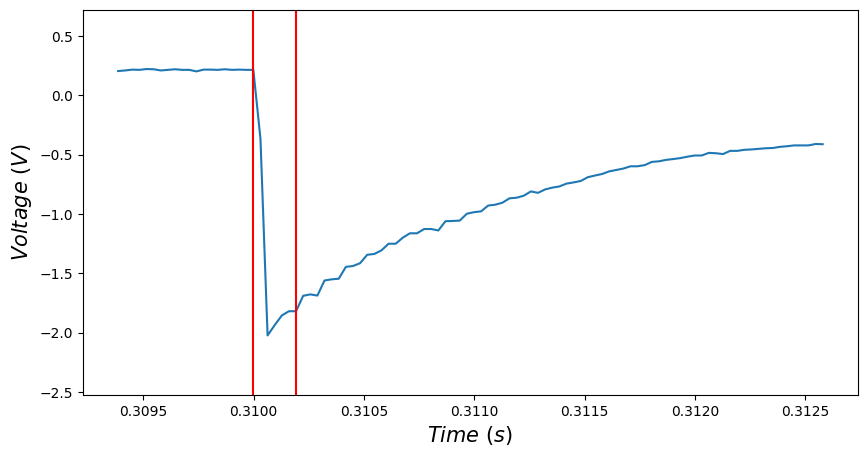

[9.67838719e-05 9.67838719e-05 9.67838719e-05 9.67838719e-05
 9.67838719e-05]
Average time delay is 9.678387193557924e-05 ms


In [16]:
avg_t_short_12m_delay,  t_short_12m_delays = ut.avg_delay(short_12m_edges_indices, win_size, v_short_12m, t, prior_samples)

print(t_short_12m_delays)
print('Average time delay is {} ms'.format(avg_t_short_12m_delay))

In [17]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_12m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 14.206904561423677 m


In [18]:
#model performance
performance = ut.performance_metrics(12.41, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=3.228866002865217, rmse=1.796904561423677)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [19]:
short_12m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_12m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_12m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_12m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_12m_edges_indices = ut.edges_detection(v_short_12m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_12m_delay,  t_short_12m_delays = ut.avg_delay(short_12m_edges_indices, win_size, v_short_12m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_12m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_12m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(12.41)
        
short_12m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_12m = pd.DataFrame(short_12m_circuit_files)
        
df_short_12m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/12m/short-106-12-1.csv,0.000097,14.206905
1,./data/short-circuit/12m/short-106-12-10.csv,0.000097,14.206905
2,./data/short-circuit/12m/short-106-12-11.csv,0.000097,14.206905
3,./data/short-circuit/12m/short-106-12-12.csv,0.000097,14.206905
4,./data/short-circuit/12m/short-106-12-13.csv,0.000097,14.206905
5,./data/short-circuit/12m/short-106-12-14.csv,0.000097,14.206905
6,./data/short-circuit/12m/short-106-12-15.csv,0.000097,14.206905
7,./data/short-circuit/12m/short-106-12-16.csv,0.000097,14.206905
8,./data/short-circuit/12m/short-106-12-17.csv,0.000097,14.206905
9,./data/short-circuit/12m/short-106-12-18.csv,0.000097,14.206905


In [20]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=3.228866002867642, rmse=1.7969045614243517, mae=1.7969045614243517, irm=1.0)


### 17.44 m
Short circuit at 17.44 m from the input port

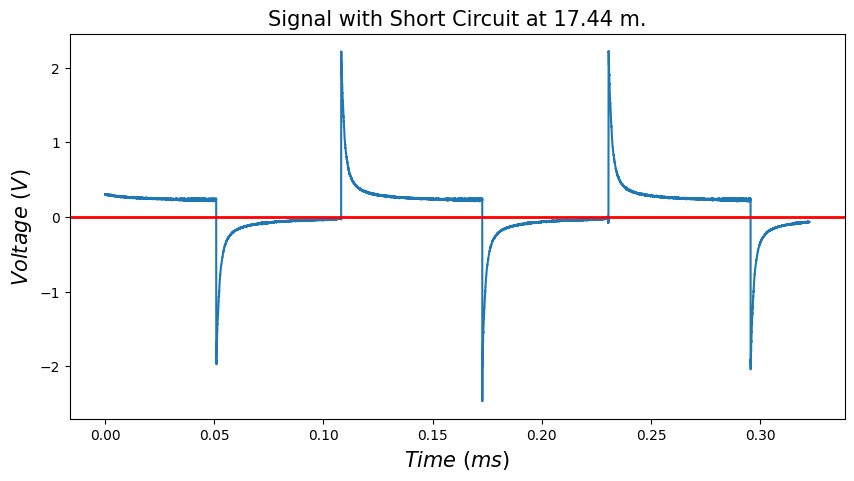

In [21]:
short_17m_files_dir = './data/short-circuit/17m'

#load a random file
v_short_17m = ut.random_file_load(short_17m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_17m, 'Signal with Short Circuit at 17.44 m.')

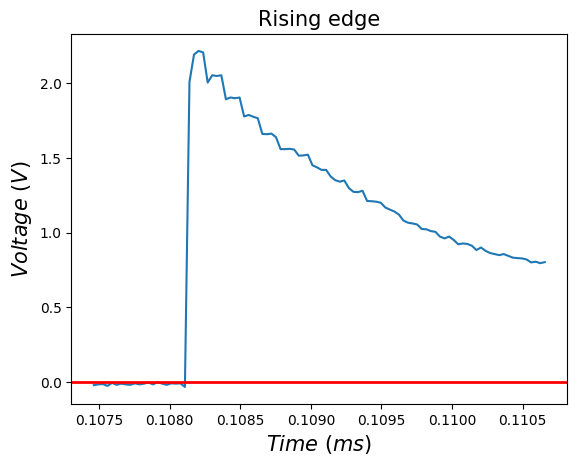

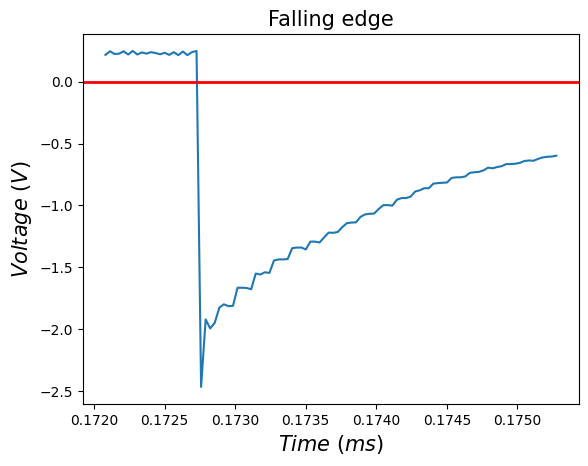

In [22]:
#locate rising a rising edge and a falling edge in the signal
short_17m_edges_indices = ut.edges_detection(v_short_17m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_17m, t, short_17m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

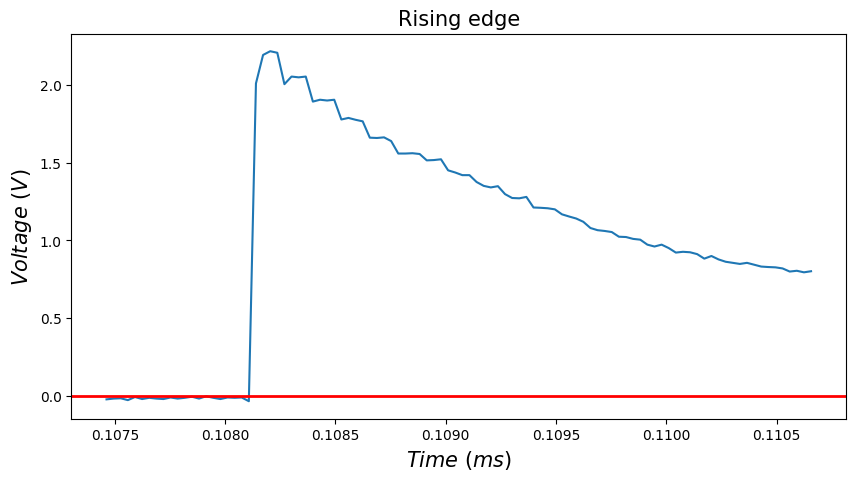

In [23]:
rising_edge_indx = short_17m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_17m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

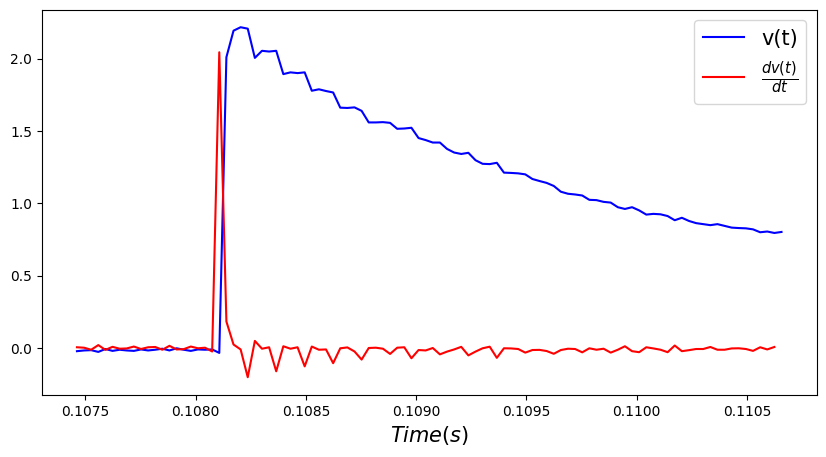

In [24]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

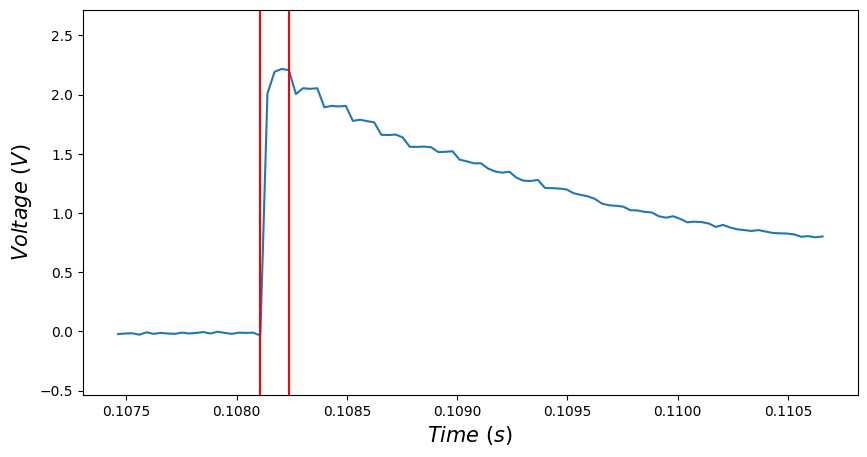

Timed delay is 0.00012904516258077647 ms


In [25]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [26]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 18.94253941523218 m


In [27]:
#model performance
performance = ut.performance_metrics(17.44, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=2.2576246943262555, rmse=1.502539415232178)


#### 2. Falling edge

Change point detection on a falling edge

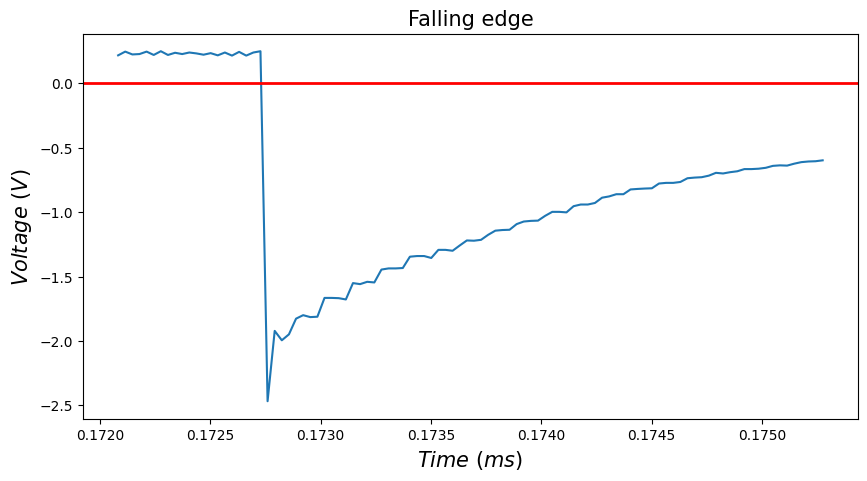

In [28]:
falling_edge_indx = short_17m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_17m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

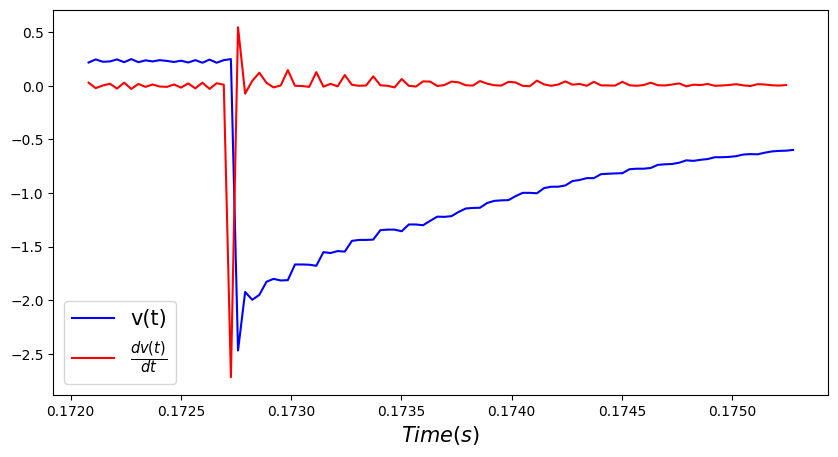

In [29]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

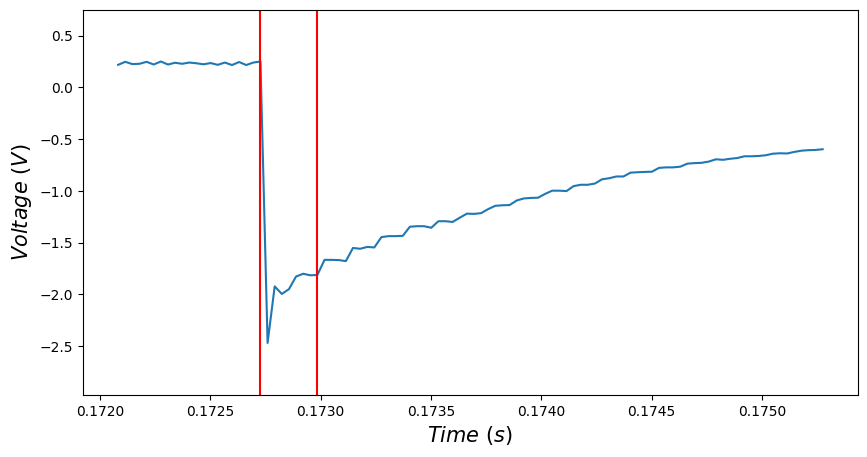

Timed delay is 0.0002580903251615252 ms


In [30]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [31]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 37.88507883046029 m


In [32]:
#model performance
performance = ut.performance_metrics(17.44, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=418.00124838373534, rmse=20.445078830460286)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [33]:
#locate rising rising edges and a falling edges in the signal
short_17m_edges_indices = ut.edges_detection(v_short_17m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_17m_edges_indices)

{'rising_edges': [7145, 3351], 'falling_edges': [5354, 9162, 1578]}


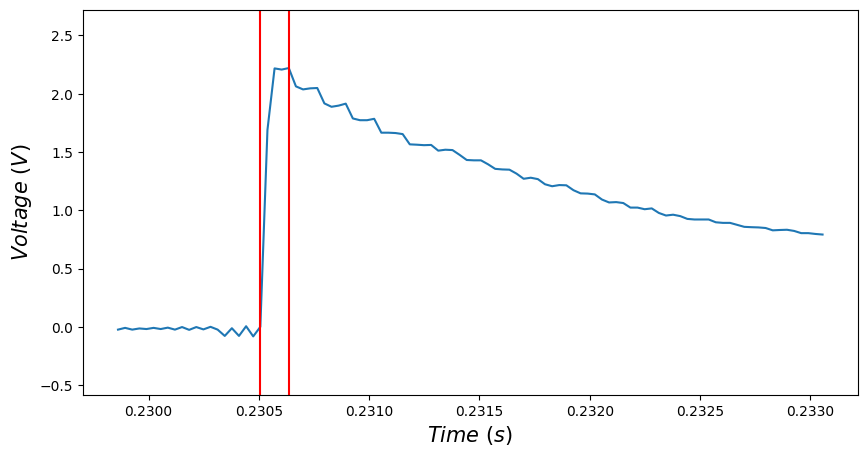

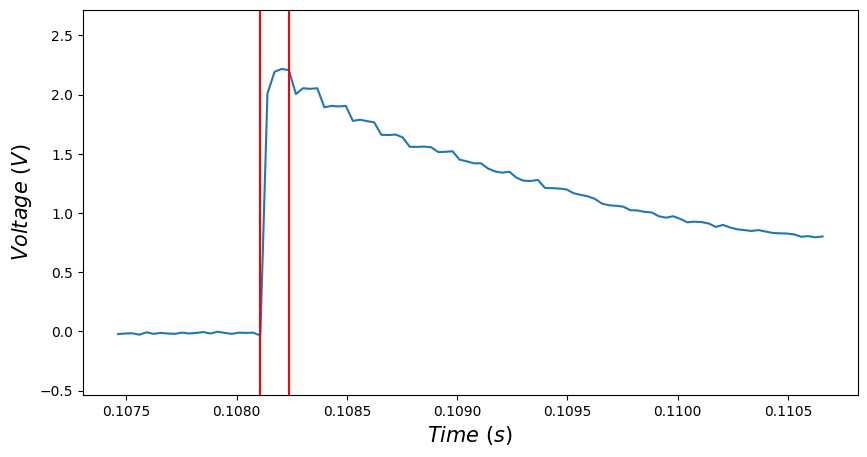

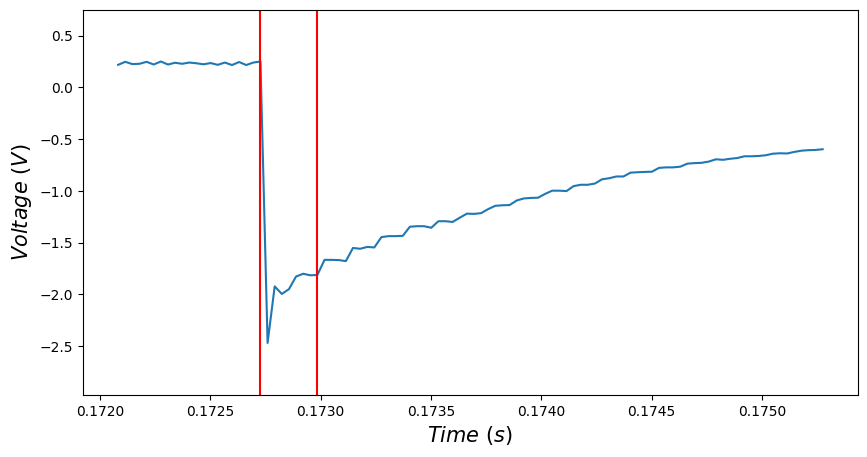

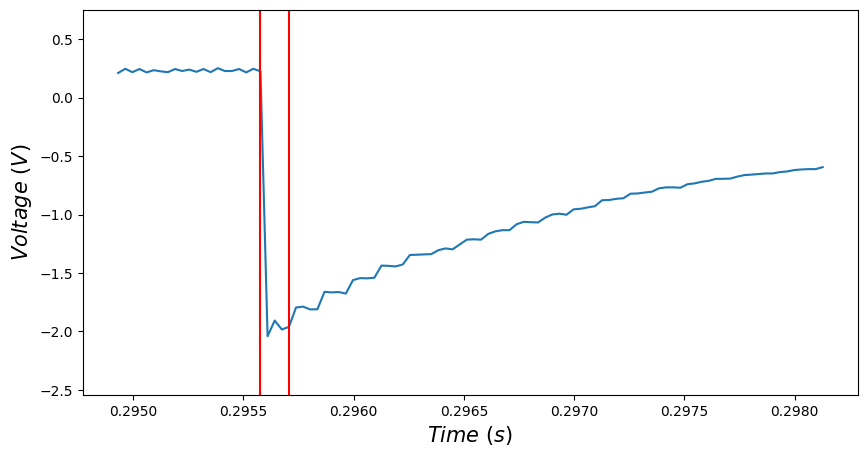

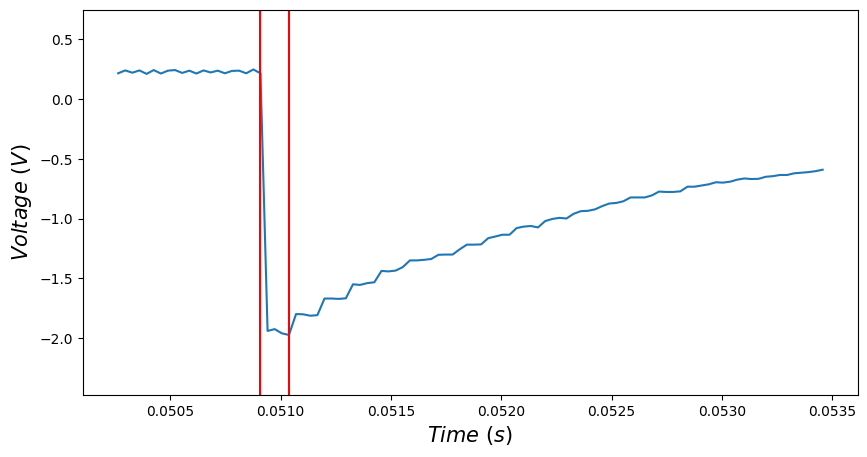

[0.00012905 0.00012905 0.00012905 0.00012905]
Average time delay is 0.00012904516258077474 ms


In [34]:
avg_t_short_17m_delay,  t_short_17m_delays = ut.avg_delay(short_17m_edges_indices, win_size, v_short_17m, t, prior_samples)

print(t_short_17m_delays)
print('Average time delay is {} ms'.format(avg_t_short_17m_delay))

In [35]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_17m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 18.942539415231924 m


In [36]:
#model performance
performance = ut.performance_metrics(17.44, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=2.2576246943254867, rmse=1.5025394152319222)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [37]:
short_17m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_17m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_17m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_17m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_17m_edges_indices = ut.edges_detection(v_short_17m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_17m_delay,  t_short_17m_delays = ut.avg_delay(short_17m_edges_indices, win_size, v_short_17m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_17m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_17m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(17.44)
        
short_17m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_17m = pd.DataFrame(short_17m_circuit_files)
        
df_short_17m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/17m/short-106-17-1.csv,0.000129,18.942539
1,./data/short-circuit/17m/short-106-17-10.csv,0.000129,18.942539
2,./data/short-circuit/17m/short-106-17-11.csv,0.000129,18.942539
3,./data/short-circuit/17m/short-106-17-12.csv,0.000129,18.942539
4,./data/short-circuit/17m/short-106-17-13.csv,0.000129,18.942539
5,./data/short-circuit/17m/short-106-17-14.csv,0.000129,18.942539
6,./data/short-circuit/17m/short-106-17-15.csv,0.000129,18.942539
7,./data/short-circuit/17m/short-106-17-16.csv,0.000129,18.942539
8,./data/short-circuit/17m/short-106-17-17.csv,0.000129,18.942539
9,./data/short-circuit/17m/short-106-17-18.csv,0.000129,18.942539


In [38]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=4.003205337972313, rmse=2.0008011740231244, mae=1.728045836841611, irm=0.9523809523809523)
